In [15]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

Num GPUs Available:  0
Num CPUs Available:  1


## Modele BERT

Ici, nous allons utiliser un modele BERT pour faire des predictions sur des textes. It's already trained.

## Context
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

In [17]:
import pandas as pd

# import csv
raw_data = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding='latin-1', names=['target', 'ids', 'date', 'flag', 'user', 'text'])
raw_data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Content
It contains the following 6 fields:
1. target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
2. ids: The id of the tweet
3. date: the date of the tweet
4. flag: The query. If there is no query, then this value is NO_QUERY.
5. user: the user that tweeted
6. text: the text of the tweet

In [18]:
sample_size = 20000 # Number of tweets to use for this notebook

data = raw_data.sample(sample_size).copy(deep=True)
data['target'] = data['target'].map(lambda x: 1 if x == 4 else 0).astype('bool')
data['ids'] = data['ids'].astype('str')
data['date'] = data['date'].astype('str') # We will convert them to date if useful later, now we just want to reduce the size of the dataframe
data['flag'] = data['flag'].astype('str')
data['user'] = data['user'].astype('str')
data['text'] = data['text'].astype('str')

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, DetCurveDisplay, ConfusionMatrixDisplay
from transformers import pipeline

def process_BERT_result_score(result):
    # print(result)

    final_score = None

    label = result[0]['label']

    # The result score goes from 0.5 to 1.0 and is labeled as POSITIVE or NEGATIVE. If the score is 0.5, it means that the model is not confident enough to make a decision.
    # We need a score that goes from 0 to 1.0 and 0 is sure it is negative and 1 is sure it is positive. 0.5 must be hard to predict.
    # If the prediction is labeled POSITIVE, we keep the score as it is.
    # If the prediction is labeled NEGATIVE, we need to scale the score from 0 to 0.5 with 0.5 being unsure if it really is negative.
    result_score = result[0]['score']

    if label == 'POSITIVE':
        final_score = result_score
    else:
        final_score = 1 - result_score
    
    # print(f"{label} : {final_score}")
    return final_score

def evaluate_roc_det(Y_test, Y_pred):
    # two subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    ax_roc = axs[0]
    ax_det = axs[1]

    ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
    ax_det.set_title("Detection Error Tradeoff (DET) curves")

    DetCurveDisplay.from_predictions(Y_test, Y_pred, ax=ax_det)
    RocCurveDisplay.from_predictions(Y_test, Y_pred, ax=ax_roc)
    plt.gcf().set_facecolor('white')
    plt.show()
    

def evaluate_confusion_matrix(Y_test, Y_pred, threshold, ax = None):
    binary_pred = np.where(Y_pred > threshold, 1, 0)
    ConfusionMatrixDisplay.from_predictions(Y_test, binary_pred, ax=ax)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceCla

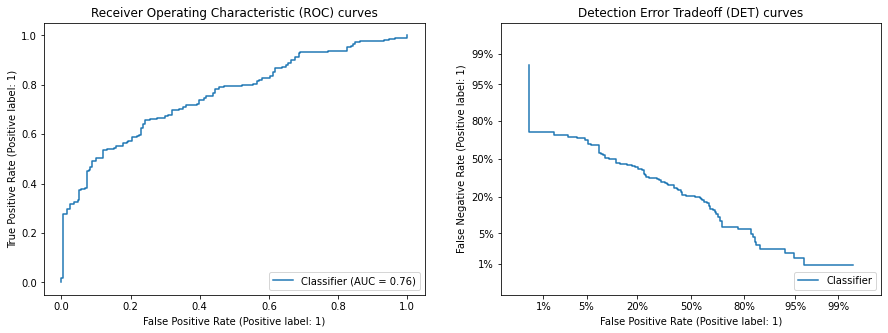

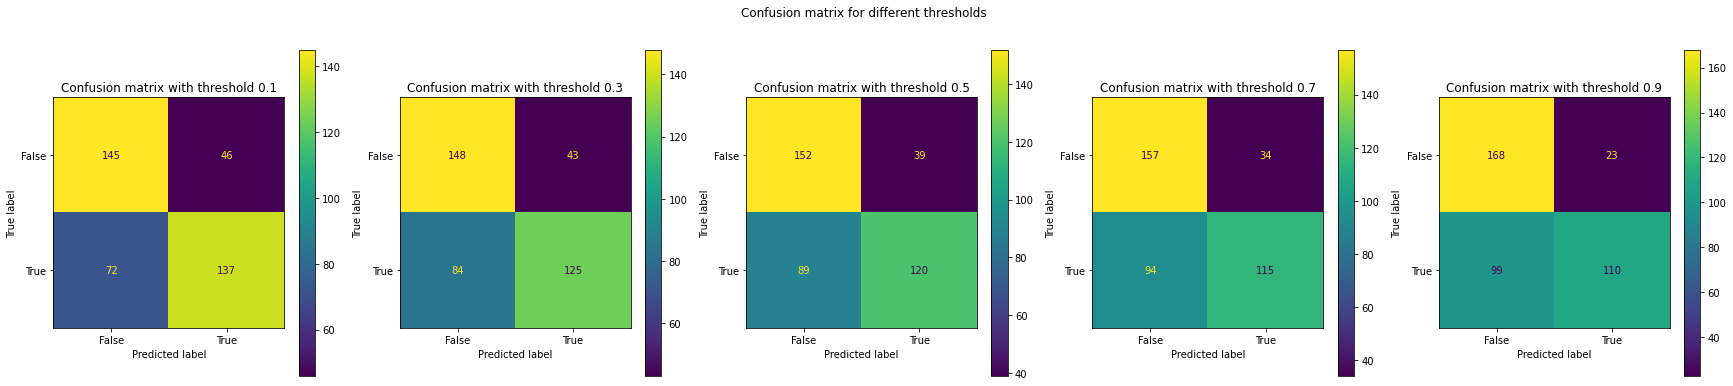

In [48]:
import numpy as np

nb_tweets = 400

X_test = data['text'][:nb_tweets]
Y_test = data['target'][:nb_tweets]

bert_classifier = pipeline("sentiment-analysis")
Y_pred = []
for i in range(len(X_test)):
    result = bert_classifier(X_test.iloc[i])
    Y_pred.append(process_BERT_result_score(result))

evaluate_roc_det(Y_test, Y_pred)

possible_thresholds = np.linspace(0.1, 0.9, 5)
fig, axs = plt.subplots(1, len(possible_thresholds), figsize=(6*len(possible_thresholds), 6))
fig.suptitle("Confusion matrix for different thresholds")

for threshold, ax in zip(possible_thresholds, axs.ravel()):
    evaluate_confusion_matrix(Y_test, Y_pred, threshold, ax = ax)
    ax.set_title(f"Confusion matrix with threshold {round(threshold, 1)}")
plt.gcf().set_facecolor('white')
plt.show()